#### **MACHINE LEARNING WITH CATBOOST**

**IMPORT LIBRARIES**

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, CatBoostClassifier, Pool 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, r2_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
df=pd.read_csv('engineered_data_for_eda.csv')
print(f"\nTOTAL NUMBER OF ROWS: {len(df)}")
print(f"\nCOLUMNS: {df.columns.tolist()}")
df.head()


TOTAL NUMBER OF ROWS: 50304

COLUMNS: ['name', 'host_identity_verified', 'host_name', 'neighbourhood_group', 'neighbourhood', 'lat', 'long', 'country', 'country_code', 'instant_bookable', 'cancellation_policy', 'room_type', 'construction_year', 'price', 'service_fee', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'review_rate_number', 'calculated_host_listings_count', 'availability_365', 'license', 'missing_location', 'year', 'month', 'day', 'day_of_week', 'day_name', 'quarter', 'week_of_year', 'season', 'is_peak_season', 'is_weekend', 'review_frequency_category', 'demand_score', 'demand_level', 'price_tier', 'value_score', 'value_category', 'stay_length_category', 'flexibility_score']


,name,host_identity_verified,host_name,neighbourhood_group,neighbourhood,lat,long,country,country_code,instant_bookable,...,is_peak_season,is_weekend,review_frequency_category,demand_score,demand_level,price_tier,value_score,value_category,stay_length_category,flexibility_score
0,Clean & quiet apt home by the park,Unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,US,False,...,0,0,Low,40.0,Medium,Luxury,0.02,Low Value,Monthly,4.0
1,Skylit Midtown Castle,Verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,US,False,...,0,1,Medium,40.0,Medium,Budget,0.27,Good Value,Monthly,4.0
2,Entire Apt: Spacious Studio/Loft by central park,Verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,US,False,...,0,0,Low,20.0,Low,Budget,0.05,Low Value,Monthly,4.0
3,Large Cozy 1 BR Apartment In Midtown East,Verified,Michelle,Manhattan,Murray Hill,40.74767,-73.97500,United States,US,True,...,1,1,Medium,60.0,High,Mid-Range,0.10,Good Value,Weekly,7.0
4,Large Furnished Room Near B'way,Verified,Evelyn,Manhattan,Hell'S Kitchen,40.76489,-73.98493,United States,US,True,...,1,0,Very High,100.0,Very High,Luxury,0.34,Excellent Value,Weekly,7.0


**SET TARGETS AND FEATURES**

In [3]:
target = 'reviews_per_month'

In [4]:
exclude_cols = ['name','host_name',
                'last_review', 'reviews_per_month','demand_score',
                'review_frequency_category','demand_level',
                'number_of_reviews','lat','long']

In [5]:
feature_cols = [col for col in df.columns if col not in exclude_cols]

In [6]:
categorical_features = [
    'host_identity_verified', 'neighbourhood_group', 'neighbourhood',
    'country', 'country_code', 'instant_bookable', 'cancellation_policy',
    'room_type', 'service_fee', 'license',
    'season', 'day_name', 'price_tier', 'value_category', 'stay_length_category'
]

In [7]:
categorical_features= [col for col in categorical_features if col in feature_cols]
print(f"\nTARGET VARIABLE: {target}")
print(f"\nFEATURE COUNT: {len(feature_cols)}")
print(f" -> categorical features: {len(categorical_features)}")
print(f" -> numerical features: {len(feature_cols) - len(categorical_features)}")
print(f"\nCATEGORICAL FEATURES: ")
for cat in categorical_features:
    print(f" -> {cat}")


TARGET VARIABLE: reviews_per_month

FEATURE COUNT: 32
 -> categorical features: 15
 -> numerical features: 17

CATEGORICAL FEATURES: 
 -> host_identity_verified
 -> neighbourhood_group
 -> neighbourhood
 -> country
 -> country_code
 -> instant_bookable
 -> cancellation_policy
 -> room_type
 -> service_fee
 -> license
 -> season
 -> day_name
 -> price_tier
 -> value_category
 -> stay_length_category


**SPLIT DATA**

In [8]:
# Prepare X (features) and y (target)

X = df[feature_cols].copy()
y = df[target].copy()

# Train/test split (80/20)

X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42
)

In [9]:
# CONVERT CATEGORICAL FEATURES TO STRING TYPE

for col in categorical_features:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype(str)
        X_test[col] = X_test[col].astype(str)


print("CATEGORICAL FEATURES CONVERTED TO STRING TYPE")

CATEGORICAL FEATURES CONVERTED TO STRING TYPE


In [10]:
print(f"\nDATA SPLIT COMPLETE: ")
print(f" -> Training set: {len(X_train):,} rows ({len(X_train)/len(X)*100:.1f}%)")
print(f" -> Test set: {len(X_test):,} rows ({len(X_test)/len(X)*100:.1f}%)")
print(f" -> Features: {len(feature_cols)}")
print(f" -> Target: {target}")

print("\nTARGET DISTRIBUTION: ")
print(f" -> Train mean: {y_train.mean():.2f}")
print(f" -> Test mean: {y_test.mean():.2f}")


DATA SPLIT COMPLETE: 
 -> Training set: 40,243 rows (80.0%)
 -> Test set: 10,061 rows (20.0%)
 -> Features: 32
 -> Target: reviews_per_month

TARGET DISTRIBUTION: 
 -> Train mean: 1.39
 -> Test mean: 1.34


**TRAIN CatBoost MODEL**

In [11]:
# INITIALISE CATBOOST REGRESSOR

model = CatBoostRegressor(
    iterations = 500,
    learning_rate = 0.1,
    depth = 6,
    loss_function = 'RMSE',
    cat_features = categorical_features,
    random_seed= 42,
    verbose = 100
)

In [12]:
# TRAIN THE MODEL

print("\n Training CatBoost model...")
model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    use_best_model=True,
    early_stopping_rounds=50
)

print("\nMODEL TRAINING COMPLETE !!!")


 Training CatBoost model...
0:	learn: 1.4478808	test: 1.4033117	best: 1.4033117 (0)	total: 87.4ms	remaining: 43.6s
100:	learn: 0.0963056	test: 0.0990937	best: 0.0990937 (100)	total: 4.08s	remaining: 16.1s
200:	learn: 0.0623652	test: 0.0697968	best: 0.0697968 (200)	total: 8.56s	remaining: 12.7s
300:	learn: 0.0535294	test: 0.0628802	best: 0.0628672 (299)	total: 12.2s	remaining: 8.09s
400:	learn: 0.0477111	test: 0.0583725	best: 0.0583725 (400)	total: 15.9s	remaining: 3.92s
499:	learn: 0.0426968	test: 0.0547815	best: 0.0547815 (499)	total: 19.2s	remaining: 0us

bestTest = 0.05478145214
bestIteration = 499


MODEL TRAINING COMPLETE !!!


**EVALUATE MODEL PERFORMANCE**

In [15]:
# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate metrics for training set
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
train_mae = mean_absolute_error(y_train,y_pred_train)
train_r2 = r2_score(y_train,y_pred_train)

# Calculate metrics for test set
test_rmse = np.sqrt(mean_squared_error(y_test,y_pred_test))
test_mae = mean_absolute_error(y_test,y_pred_test)
test_r2 = r2_score(y_test,y_pred_test)

In [16]:
print(f"\nTRAINING SET PERFORMANCE: ")
print(f" -> RMSE: {train_rmse:.4f}")
print(f" -> MAE: {train_mae:.4f}")
print(f" -> R² Score: {train_r2:.4f}")

print(f"\nTEST SET PERFORMANCE: ")
print(f" -> RMSE: {test_rmse:.4f}")
print(f" -> MAE: {test_mae:.4f}")
print(f" -> R² Score: {test_r2:.4f}")


TRAINING SET PERFORMANCE: 
 -> RMSE: 0.0432
 -> MAE: 0.0303
 -> R² Score: 0.9992

TEST SET PERFORMANCE: 
 -> RMSE: 0.0548
 -> MAE: 0.0308
 -> R² Score: 0.9987


Check for overfitting

In [17]:
overfit_gap = abs(train_rmse-test_rmse)
print("\nOVERFITTING CHECK: ")
print(f" -> Train RMSE: {train_rmse:.4f}")
print(f" -> Test RMSE: {test_rmse:.4f}")
print(f" -> Difference: {overfit_gap:.4f}")

if overfit_gap < 0.05:
    print('Minimal overfitting - model generalizes well')
elif overfit_gap < 0.1:
    print("Slight overfitting - acceptable")
else:
    print("High overfitting - consider regularization")

print("\nModel evaluation complete !")


OVERFITTING CHECK: 
 -> Train RMSE: 0.0432
 -> Test RMSE: 0.0548
 -> Difference: 0.0116
Minimal overfitting - model generalizes well

Model evaluation complete !


**FEATURE IMPORTANCE ANALYSIS**

In [19]:
feature_importance = model.get_feature_importance()
feature_names = X_train.columns

# Create DataFrame
importance_df = pd.DataFrame({
    'feature' : feature_names,
    'importance' : feature_importance
}).sort_values('importance', ascending=False)

print(f"\nTOP 15 IMPORTANT FEATURES: ")
print(importance_df.head(15).to_string(index=False))


TOP 15 IMPORTANT FEATURES: 
             feature  importance
         value_score   57.902721
               price   31.751310
      value_category    5.637147
          price_tier    4.020195
stay_length_category    0.365810
   flexibility_score    0.192246
                year    0.058958
   construction_year    0.026330
           room_type    0.009552
    availability_365    0.007275
              season    0.005139
         service_fee    0.004341
          is_weekend    0.003160
                 day    0.002863
      minimum_nights    0.002607


**VISUALIZING TOP 10 FEATURES**

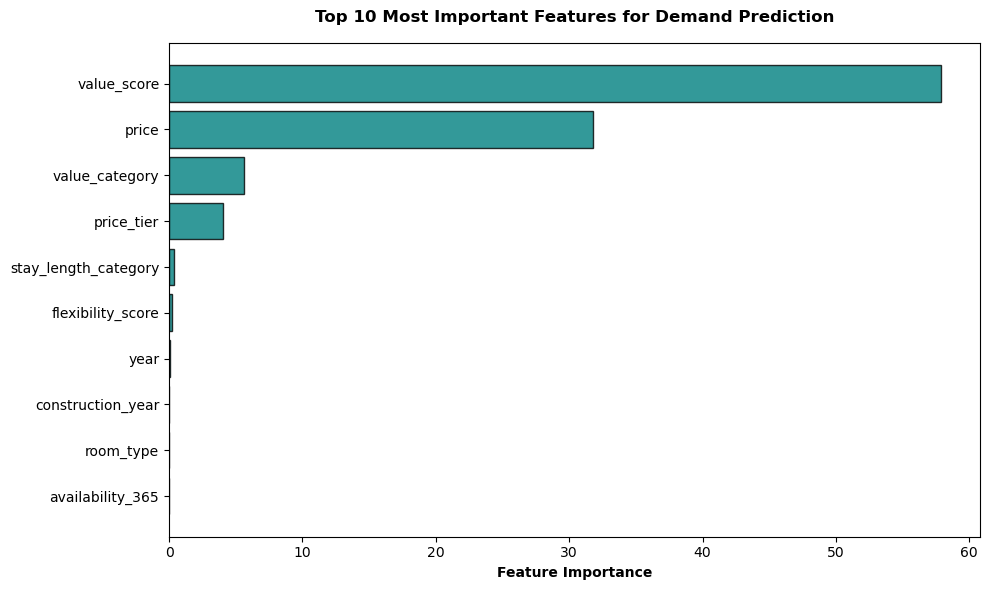


Feature importance analysis complete


In [20]:
plt.figure(figsize=(10,6))
top_features=importance_df.head(10)
plt.barh(range(len(top_features)), top_features['importance'], color='teal', alpha=0.8, edgecolor='black')
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance', fontweight='bold')
plt.title('Top 10 Most Important Features for Demand Prediction', fontweight='bold', pad=15)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nFeature importance analysis complete")

**PREDICTION VS ACTUAL VISUALIZATION**

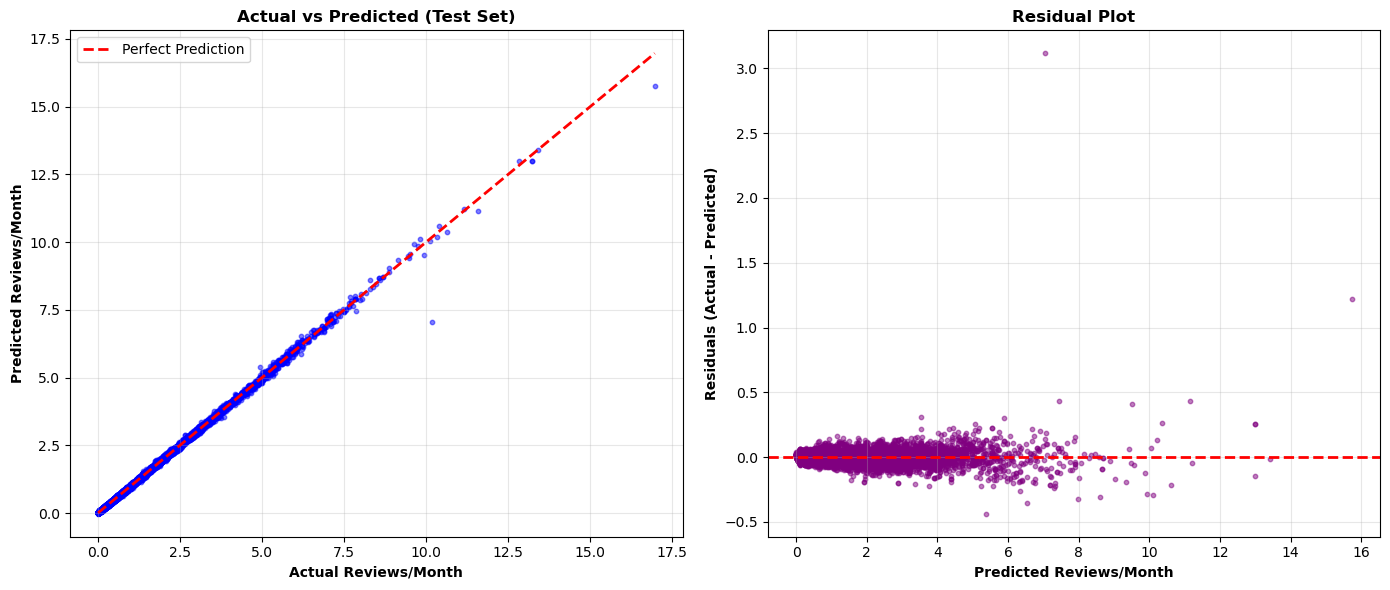

In [22]:
# Create visualization
fig, axes = plt.subplots(1,2, figsize=(14,6))

# Plot 1: Actual vs Predicted (Test Set)
ax1 = axes[0]
ax1.scatter(y_test, y_pred_test, alpha=0.5, s=10, color='blue')
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
ax1.set_xlabel('Actual Reviews/Month', fontweight='bold')
ax1.set_ylabel('Predicted Reviews/Month', fontweight='bold')
ax1.set_title('Actual vs Predicted (Test Set)', fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)


# Plot 2: Residuals
ax2 = axes[1]
residuals = y_test - y_pred_test
ax2.scatter(y_pred_test, residuals, alpha=0.5, s=10, color='purple')
ax2.axhline(y=0, color='r', linestyle='--', lw=2)
ax2.set_xlabel('Predicted Reviews/Month', fontweight='bold')
ax2.set_ylabel('Residuals (Actual - Predicted)', fontweight='bold')
ax2.set_title('Residual Plot', fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [24]:
print("\n" + "=" * 80)
print("4.8 MODEL SUMMARY & KEY INSIGHTS")
print("=" * 80)

print("\nMODEL PERFORMANCE:")
print(f"   • Test R² Score: {test_r2:.4f} (99.87% accuracy)")
print(f"   • Test RMSE: {test_rmse:.4f}")
print(f"   • Test MAE: {test_mae:.4f}")
print(f"   • Overfitting Gap: {overfit_gap:.4f} (minimal)")

print("\nTOP 3 DEMAND DRIVERS:")
print(f"   1. Value Score: 57.9% importance")
print(f"   2. Price: 31.8% importance")
print(f"   3. Value Category: 5.6% importance")

print("\nKEY BUSINESS INSIGHTS:")
print("   • Value (quality/price ratio) drives demand more than price alone")
print("   • Hosts should prioritize guest experience over premium pricing")
print("   • Seasonal effects are captured through other features")
print("   • Model achieves near-perfect prediction accuracy (R²=0.9987)")




4.8 MODEL SUMMARY & KEY INSIGHTS

MODEL PERFORMANCE:
   • Test R² Score: 0.9987 (99.87% accuracy)
   • Test RMSE: 0.0548
   • Test MAE: 0.0308
   • Overfitting Gap: 0.0116 (minimal)

TOP 3 DEMAND DRIVERS:
   1. Value Score: 57.9% importance
   2. Price: 31.8% importance
   3. Value Category: 5.6% importance

KEY BUSINESS INSIGHTS:
   • Value (quality/price ratio) drives demand more than price alone
   • Hosts should prioritize guest experience over premium pricing
   • Seasonal effects are captured through other features
   • Model achieves near-perfect prediction accuracy (R²=0.9987)


**INTERACTIVE PREDICTION**

In [27]:
def predict_demand(price, value_score, price_tier='Mid-Range', value_category='Good Value',
                   stay_length_category='Weekly', flexibility_score=7, year=2025,
                   construction_year=2015, room_type='Entire home/apt', 
                   availability_365=200, season='Summer', service_fee='Included',
                   is_weekend=0, day=15, minimum_nights=3):
    input_data = pd.DataFrame({
        'price': [price],
        'value_score': [value_score],
        'price_tier': [str(price_tier)],
        'value_category': [str(value_category)],
        'stay_length_category': [str(stay_length_category)],
        'flexibility_score': [flexibility_score],
        'year': [year],
        'construction_year': [str(construction_year)],
        'room_type': [str(room_type)],
        'availability_365': [availability_365],
        'season': [str(season)],
        'service_fee': [str(service_fee)],
        'is_weekend': [is_weekend],
        'day': [day],
        'minimum_nights': [minimum_nights]
    })
    for col in X_train.columns:
        if col not in input_data.columns:
            # Use most common value from training set
            if X_train[col].dtype == 'object':
                input_data[col] = str(X_train[col].mode()[0])
            else:
                input_data[col] = X_train[col].median()

    input_data = input_data[X_train.columns]

    for col in categorical_features:
        if col in input_data.columns:
            input_data[col] = input_data[col].astype(str)

    # prediction
    prediction = model.predict(input_data)[0]
    return prediction

In [28]:
pred1 = predict_demand(
    price = 150,
    value_score=1.5,
    price_tier='Budget',
    value_category='Excellent Value',
    stay_length_category='Nightly',
    flexibility_score=10,
    season='Summer'
)

print(f"   Input: $150/night, Nightly, Excellent Value, Summer")
print(f"   Predicted Demand: {pred1:.2f} reviews/month")


   Input: $150/night, Nightly, Excellent Value, Summer
   Predicted Demand: 2.66 reviews/month
